In [9]:
import pandas as pd
import numpy as np

import tensorflow as tf
import multiprocessing

num_cores = multiprocessing.cpu_count()
tf.config.threading.set_intra_op_parallelism_threads(num_cores)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import Dense, Input, concatenate
from keras.models import Model
from keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Set the aesthetics for the plots
sns.set(style="whitegrid")

TRAIN_SMALL = "./etc/training_small.csv"
TRAIN_LARGE = "./etc/training_large.csv"
TEST = "./etc/test.csv"

FEATURES = ['overall_rating', 'firm', 'pros', 'cons']
TARGET = 'overall_rating'

In [ ]:
# Features to use:
# 1. Sentiment score for pros
# 2. Sentiment score for cons
# 3. Encoded firm
# 4. Length for pros
# 5. Length for cons

In [4]:
def plot_features(preprocessed_train: pd.DataFrame, preprocessed_test: pd.DataFrame):
    n_rows = 3
    n_cols = 2

    # Smaller figure size
    fig_width = 10  # Adjust the width as needed
    fig_height_per_row = 4  # Smaller height per subplot row

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height_per_row * n_rows), squeeze=False)

    # Flatten the axes array for easy iteration if it's multidimensional
    axes = axes.flatten()

    # Iterate over the DataFrame's columns and create a plot for each one
    for i, col in enumerate(preprocessed_test.columns):
        sns.histplot(data=preprocessed_train, x=col, color="blue", kde=True, ax=axes[i], label='Training set (Large)')
        sns.histplot(data=preprocessed_test, x=col, color="orange", kde=True, ax=axes[i], label='Testing set')
        axes[i].set_title(f'Distribution of {col}', fontsize=10)
        axes[i].legend()  # Add a legend to each subplot

    # If there are any leftover subplots, turn them off
    for i in range(len(preprocessed_test.columns), n_rows*n_cols):
        axes[i].axis('off')

    # Adjust layout for better fit and display the plot
    plt.tight_layout()
    plt.savefig("./img/q2_features.png")
    plt.show()

def plot_preds_distributions(train_predictions, train_actuals, test_predictions):
    plt.figure(figsize=(10, 6))
    sns.distplot(train_predictions, label='Training Set Predictions', kde=True, bins=30)
    sns.distplot(train_actuals, label='Actual Training Values', kde=True, bins=30)
    sns.distplot(test_predictions, label='Test Set Predictions', kde=True, bins=30)
    plt.title('Distributions of Predictions and Actual Values')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig("./img/q2_preds.png")
    plt.show()

    
def plot_correlation_heatmap(train_df: pd.DataFrame):
    # Calculate the correlation matrix
    corr_matrix = train_df.corr()

    # Create a mask to hide the upper triangle of the heatmap (since it's a mirror of the lower triangle)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

    # Add title
    plt.title('Feature Correlation Heatmap')
    plt.savefig("./img/q2_corr_heatmap.png")
    plt.show()
    
def preprocess(df, le = None):
    df = df[FEATURES]
    
    def capped_len(x):
        temp = len(str(x))
        return min(temp, 1000)
    
    # Get lengths of pros and cons
    print("Applying len")
    ss1 = StandardScaler()
    ss2 = StandardScaler()
    df.loc[:, "pros_length_scaled"] = ss1.fit_transform(df["pros"].apply(capped_len).to_numpy().reshape(-1, 1)).flatten()
    df.loc[:, "cons_length_scaled"] = ss2.fit_transform(df["cons"].apply(capped_len).to_numpy().reshape(-1, 1)).flatten()
    
    # Get sentiment scores for pros and cons
    print("Getting sentiment scores")
    sia = SentimentIntensityAnalyzer()
    df.loc[:, "pros_sentiment"] = df["pros"].apply(lambda x: sia.polarity_scores(str(x))["compound"])
    df.loc[:, "cons_sentiment"] = df["cons"].apply(lambda x: sia.polarity_scores(str(x))["compound"])
    
    # Encode firm
    print("Encoding firm")
    if (le is None):
        le = LabelEncoder()

    df["firm_encoded"] = le.fit_transform(df["firm"])
    
    df.drop(["firm", "pros", "cons"], axis=1, inplace=True)
    
    print("Done")
    
    df.to_csv("./etc/saved_df.csv")
    
    return df, le

In [5]:
data = pd.read_csv(TRAIN_LARGE, engine="python")
print("Read data. Preprocessing")
data, le = preprocess(data)
print("Finished preprocessing")
data.head()

Read data. Preprocessing
Applying len


/tmp/ipykernel_657453/1460098368.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "pros_length_scaled"] = ss1.fit_transform(df["pros"].apply(capped_len).to_numpy().reshape(-1, 1)).flatten()
/tmp/ipykernel_657453/1460098368.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "cons_length_scaled"] = ss2.fit_transform(df["cons"].apply(capped_len).to_numpy().reshape(-1, 1)).flatten()


Getting sentiment scores


/tmp/ipykernel_657453/1460098368.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "pros_sentiment"] = df["pros"].apply(lambda x: sia.polarity_scores(str(x))["compound"])
/tmp/ipykernel_657453/1460098368.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "cons_sentiment"] = df["cons"].apply(lambda x: sia.polarity_scores(str(x))["compound"])
/tmp/ipykernel_657453/1460098368.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Encoding firm
Done
Finished preprocessing


,overall_rating,pros_length_scaled,cons_length_scaled,pros_sentiment,cons_sentiment,firm_encoded
0,1,-0.450154,-0.596687,0.4939,-0.6133,178
1,4,-0.486444,-0.498484,0.4404,0.0000,114
2,3,2.271584,1.101655,0.9633,0.4588,178
3,4,1.291758,1.500245,0.8510,0.9569,235
4,5,1.727236,0.113844,0.9678,-0.1027,78


In [7]:
# Step 1: Import libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Step 3: Split the data into features and target
X = data[['pros_length_scaled', 'cons_length_scaled', 'pros_sentiment', 'cons_sentiment', 'firm_encoded']]
y = data['overall_rating']

print("splitting")

# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Split.")

# Step 5: Create and train the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

print("Fit initial model.")

# Step 6: Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

splitting
Split.
Fit initial model.
Accuracy: 0.4290835861869672


In [10]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': list(range(100, 300, 50)),
    'max_depth': list(range(5, 16, 2)),
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5)

# Fit GridSearchCV to the training data
CV_rfc.fit(X_train, y_train)

# Evaluate the best model from GridSearchCV
best_model = CV_rfc.best_estimator_
y_pred_best = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Best Model Accuracy: {best_accuracy}")

# Print the best parameters
print("Best Parameters:", CV_rfc.best_params_)

/srv/jupyter_python3-extra/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/srv/jupyter_python3-extra/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/srv/jupyter_python3-extra/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this paramet

KeyboardInterrupt: 

In [4]:
# Split into training and testing
print("Splitting data")
(
    X_train_pros_length, X_test_pros_length,
    X_train_cons_length, X_test_cons_length,
    X_train_pros_sentiment, X_test_pros_sentiment,
    X_train_cons_sentiment, X_test_cons_sentiment,
    X_train_firm_encoded, X_test_firm_encoded,
    y_train, y_test
) = train_test_split(
        data['pros_length_scaled'], data['cons_length_scaled'], data['pros_sentiment'], data['cons_sentiment'], data['firm_encoded'],
        data['overall_rating'],
        test_size=0.2,
        random_state=42
    )
print("Done splitting data!")

Splitting data
Done splitting data!


In [7]:
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

# Define NN
# Multiple inputs
input_pros_length = Input(shape=(1,))
input_cons_length = Input(shape=(1,))
input_pros_sentiment = Input(shape=(1,))
input_cons_sentiment = Input(shape=(1,))
input_firm_encoded = Input(shape=(1,))

DENSE_UNITS = 16
dense_pros_length = Dense(DENSE_UNITS, activation='tanh')(input_pros_length)
dense_cons_length = Dense(DENSE_UNITS, activation='tanh')(input_cons_length)
dense_pros_sentiment = Dense(DENSE_UNITS, activation='tanh')(input_pros_sentiment)
dense_cons_sentiment = Dense(DENSE_UNITS, activation='tanh')(input_cons_sentiment)
dense_firm_encoded = Dense(DENSE_UNITS, activation='tanh')(input_firm_encoded)

# Combine the input from all layers
layers = [dense_pros_length, dense_cons_length, dense_pros_sentiment, dense_cons_sentiment, dense_firm_encoded]
concatenated = concatenate(layers)

# And apply a regression layer
dense_layer = Dense(16, activation='relu')(concatenated)
output = Dense(1, activation='linear')(dense_layer)

train_inputs = [input_pros_length, input_cons_length, input_pros_sentiment, input_cons_sentiment, input_firm_encoded]
model = Model(train_inputs, output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', r_squared])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [11]:
# Train the model
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
X_train_inputs = [X_train_pros_length, X_train_cons_length, X_train_pros_sentiment, X_train_cons_sentiment, X_train_firm_encoded]
X_test_inputs = [X_test_pros_length, X_test_cons_length, X_test_pros_sentiment, X_test_cons_sentiment, X_test_firm_encoded]
# history = model.fit(
#                 X_train_inputs,
#                 y_train,
#                 epochs=5,
#                 batch_size=64,
#                 validation_data=(
#                     X_test_inputs,
#                     y_test
#                 ),
#                 verbose=1,
#                 callbacks=[cp_callback]
#           )

In [ ]:
model.save("simple-v4")

In [8]:
model = tf.keras.models.load_model('simple-v5', custom_objects={'r_squared': r_squared})

# Show the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [9]:
test = pd.read_csv(TEST)
test, le_test = preprocess(test, le)
preds_inputs = [test['pros_length_scaled'], test['cons_length_scaled'], test['pros_sentiment'], test['cons_sentiment'], test['firm_encoded']]
preds = model.predict(
    preds_inputs,
    batch_size=64,
    verbose=1,
    use_multiprocessing=True
)

Applying len
Getting sentiment scores


/tmp/ipykernel_58990/1531140140.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "pros_length_scaled"] = ss1.fit_transform(df["pros"].apply(capped_len).to_numpy().reshape(-1, 1)).flatten()
/tmp/ipykernel_58990/1531140140.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "cons_length_scaled"] = ss2.fit_transform(df["cons"].apply(capped_len).to_numpy().reshape(-1, 1)).flatten()
/tmp/ipykernel_58990/1531140140.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Encoding firm
Done
891/891 [==============================] - 27s 30ms/step


In [ ]:
# Q2 Part 1
plot_features(data, test)

In [14]:
y_preds = model.predict(X_train_inputs)
y_preds = np.asarray(y_preds).flatten()
preds = np.asarray(preds).flatten()

# Q2 Part 2
# plot_preds_distributions(y_preds, y_train, preds)

13842/13842 [==============================] - 247s 18ms/step


/srv/jupyter_python3-extra/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/srv/jupyter_python3-extra/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/srv/jupyter_python3-extra/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

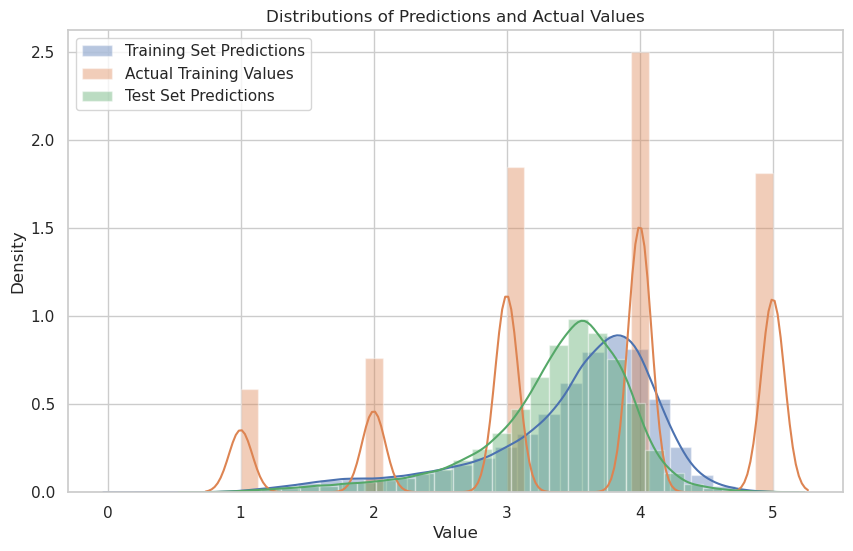

In [25]:
plot_preds_distributions(y_preds, y_train, preds)

In [23]:
mean_squared_error(y_train.values, y_preds)

0.9300273648331305

In [21]:
r2_score(y_train.values, y_preds)

0.3355269981271769

In [24]:
# Save predictions
np.savetxt('./etc/preds_simple_v6.csv', np.asarray(preds), delimiter=",", header=TARGET)

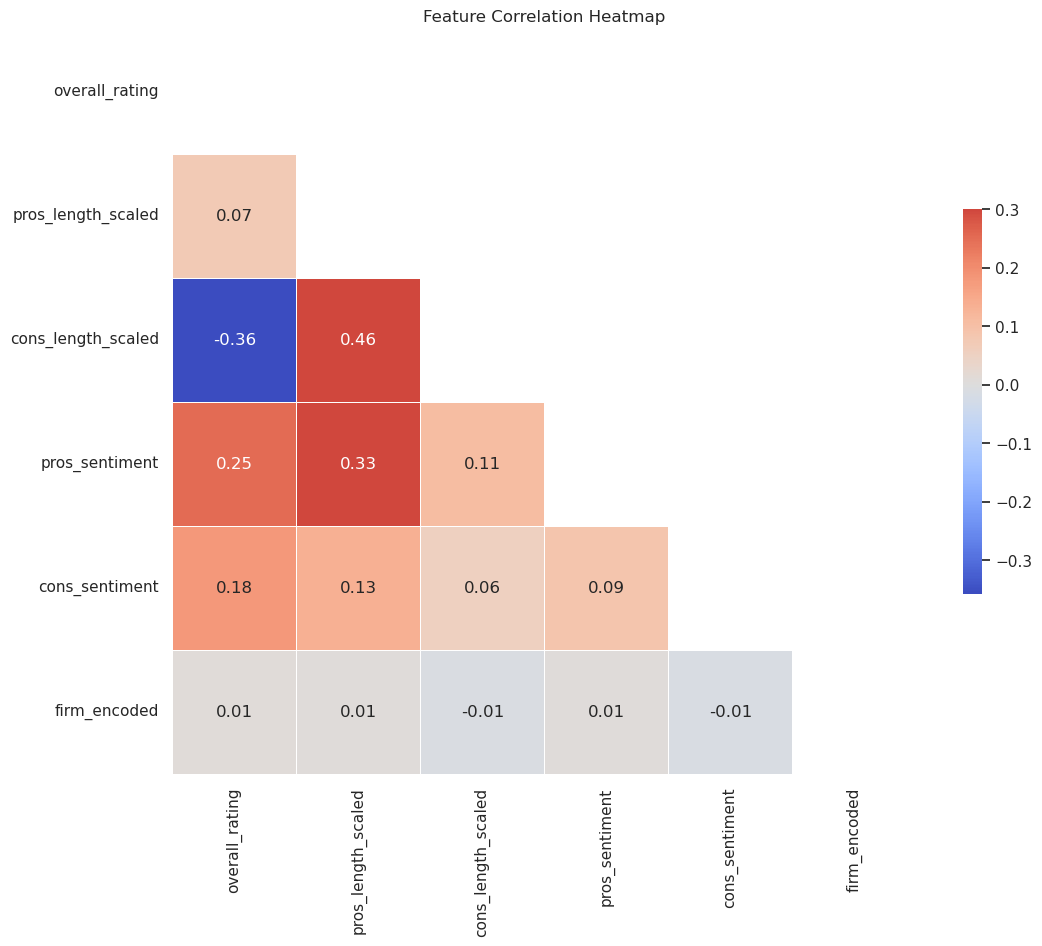

In [26]:
# Q2 Part 3
plot_correlation_heatmap(data)